In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bstudniarz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Import Dataset
df = pd.read_csv('corpus3.csv')
#print(df.labels.unique())
df.head()

,labels,texts
0,Lower leg(s),Three correctional facility guards were escort...
1,"Leg(s), n.e.c.",Employee in the Machine Shop received second d...
2,Nonclassifiable,A truck driver fell approximately 4 feet while...
3,"Leg(s), unspecified",An employee's leg was pinned between a truck a...
4,"Finger(s), fingernail(s), n.e.c.",An employee working on the Line 6 Auto-Beller ...


In [5]:
# Convert to list
data = df.texts.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['Three correctional facility guards were escorting a restrained federal '
 'prison inmate when he became disruptive, requiring the use of force. Two '
 'guards and the inmate fell onto the Lieutenants right leg, fracturing his '
 'fibula. He was transported to the hospital and released the following day.']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['three', 'correctional', 'facility', 'guards', 'were', 'escorting', 'restrained', 'federal', 'prison', 'inmate', 'when', 'he', 'became', 'disruptive', 'requiring', 'the', 'use', 'of', 'force', 'two', 'guards', 'and', 'the', 'inmate', 'fell', 'onto', 'the', 'lieutenants', 'right', 'leg', 'fracturing', 'his', 'fibula', 'he', 'was', 'transported', 'to', 'the', 'hospital', 'and', 'released', 'the', 'following', 'day']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['three', 'correctional', 'facility', 'guards', 'were', 'escorting', 'restrained', 'federal', 'prison', 'inmate', 'when', 'he', 'became', 'disruptive', 'requiring', 'the', 'use', 'of', 'force', 'two', 'guards', 'and', 'the', 'inmate', 'fell', 'onto', 'the', 'lieutenants', 'right', 'leg', 'fracturing', 'his', 'fibula', 'he', 'was', 'transported', 'to', 'the', 'hospital', 'and', 'released', 'the', 'following_day']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['correctional', 'facility', 'guard', 'escort', 'restrained', 'federal', 'prison', 'inmate', 'become', 'disruptive', 'require', 'force', 'guard', 'inmate', 'fall', 'lieutenant', 'leg', 'fracturing', 'fibula', 'transport', 'hospital', 'release', 'following_day']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [11]:
id2word[0]

'become'

In [12]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('become', 1),
  ('correctional', 1),
  ('disruptive', 1),
  ('escort', 1),
  ('facility', 1),
  ('fall', 1),
  ('federal', 1),
  ('fibula', 1),
  ('following_day', 1),
  ('force', 1),
  ('fracturing', 1),
  ('guard', 2),
  ('hospital', 1),
  ('inmate', 2),
  ('leg', 1),
  ('lieutenant', 1),
  ('prison', 1),
  ('release', 1),
  ('require', 1),
  ('restrained', 1),
  ('transport', 1)]]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.119*"time" + 0.070*"partially" + 0.053*"incident" + 0.033*"set" + '
  '0.023*"forward" + 0.022*"snow" + 0.021*"trim" + 0.019*"leak" + 0.018*"away" '
  '+ 0.017*"road"'),
 (1,
  '0.137*"door" + 0.112*"clean" + 0.055*"bar" + 0.051*"pressure" + '
  '0.048*"frame" + 0.046*"product" + 0.028*"stock" + 0.027*"room" + '
  '0.026*"take" + 0.021*"large"'),
 (2,
  '0.157*"forklift" + 0.079*"area" + 0.072*"coworker" + 0.066*"run" + '
  '0.054*"rack" + 0.029*"put" + 0.029*"meat" + 0.024*"unloading" + '
  '0.024*"upper" + 0.022*"pelvi"'),
 (3,
  '0.129*"cause" + 0.119*"ground" + 0.083*"lift" + 0.049*"come" + '
  '0.043*"vehicle" + 0.035*"contact" + 0.030*"open" + 0.027*"scaffold" + '
  '0.023*"valve" + 0.020*"system"'),
 (4,
  '0.120*"cut" + 0.107*"pipe" + 0.088*"piece" + 0.069*"blade" + 0.047*"cart" + '
  '0.038*"wall" + 0.036*"inch" + 0.030*"slide" + 0.029*"handle" + '
  '0.024*"strap"'),
 (5,
  '0.077*"burn" + 0.062*"line" + 0.052*"equipment" + 0.039*"water" + '
  '0.039*"neck" + 0.033*

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.778093119198153

Coherence Score:  0.356632093630031


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
17     27.918200        1       1 -0.363282 -0.027924
11     18.078569        1       2 -0.331300 -0.072403
16      6.804523        1       3 -0.032154  0.452532
3       4.176868        1       4  0.012962  0.033685
8       3.810043        1       5  0.008611  0.043565
5       3.603274        1       6  0.036775 -0.022546
19      3.053982        1       7  0.032731 -0.002373
4       3.033633        1       8  0.000913 -0.044334
7       2.856412        1       9  0.040094 -0.015355
0       2.813173        1      10  0.055305 -0.032615
14      2.773482        1      11  0.045994 -0.024189
10      2.738647        1      12  0.045122 -0.023208
2       2.734878        1      13  0.040645 -0.011985
13      2.645267        1      14  0.034852 -0.051183
9       2.404920        1      15  0.052986 -0.027814
15      2.194748        1      16  0.066296 -0.033648
1       2.189593        1      17  0.064935 -0.039418
6       2.153365        1      18  0.064451 -0.031717
18      2.028041        1      19  0.061798 -0.029978
12      1.988382        1      20  0.062266 -0.039091, topic_info=     Category          Freq             Term         Total  loglift  logprob
term                                                                        
23    Default  32076.000000         employee  32076.000000  30.0000  30.0000
5     Default   8423.000000             fall   8423.000000  29.0000  29.0000
93    Default   2607.000000           strike   2607.000000  28.0000  28.0000
126   Default   4844.000000            leave   4844.000000  27.0000  27.0000
56    Default   4497.000000           finger   4497.000000  26.0000  26.0000
137   Default   1979.000000             head   1979.000000  25.0000  25.0000
75    Default   4062.000000         amputate   4062.000000  24.0000  24.0000
72    Default   6121.000000            right   6121.000000  23.0000  23.0000
236   Default   1819.000000  hospitalization   1819.000000  22.0000  22.0000
59    Default   3806.000000             hand   3806.000000  21.0000  21.0000
132   Default   1956.000000            cause   1956.000000  20.0000  20.0000
42    Default   2261.000000            truck   2261.000000  19.0000  19.0000
151   Default   3393.000000            catch   3393.000000  18.0000  18.0000
123   Default   1804.000000           ground   1804.000000  17.0000  17.0000
101   Default   1587.000000              arm   1587.000000  16.0000  16.0000
304   Default   1559.000000         forklift   1559.000000  15.0000  15.0000
291   Default   1666.000000             move   1666.000000  14.0000  14.0000
25    Default   3196.000000          machine   3196.000000  13.0000  13.0000
199   Default   1338.000000              see   1338.000000  12.0000  12.0000
35    Default   3771.000000             foot   3771.000000  11.0000  11.0000
164   Default   3764.000000           suffer   3764.000000  10.0000  10.0000
131   Default   3755.000000            break   3755.000000   9.0000   9.0000
98    Default   1317.000000              cut   1317.000000   8.0000   8.0000
48    Default   1246.000000           pallet   1246.000000   7.0000   7.0000
119   Default   1215.000000             time   1215.000000   6.0000   6.0000
225   Default   1091.000000             walk   1091.000000   5.0000   5.0000
264   Default   1088.000000             door   1088.000000   4.0000   4.0000
62    Default   1176.000000             pipe   1176.000000   3.0000   3.0000
0     Default   1081.000000           become   1081.000000   2.0000   2.0000
391   Default   1251.000000             lift   1251.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
225   Topic20   1090.756958             walk   1091.712646   3.9170  -1.8891
341   Topic20    827.798767              ice    828.754456   3.9167  -2.1650
343   Topic20    583.705078      parking_lot    584.660767   3.9162  -2.51

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/bstudniarz/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('employee', 0.20111905502020516),
   ('leave', 0.12862915760024868),
   ('result', 0.09922287845819086),
   ('thumb', 0.07267640658999068),
   ('amputation', 0.05775567298725521),
   ('tip', 0.05365247124650295),
   ('catch', 0.04849238420889027),
   ('equipment', 0.03860739819707802),
   ('operate', 0.020951196767174385),
   ('edge', 0.01442337581597762)]),
 (17,
  [('employee', 0.2817378220801204),
   ('work', 0.039119804400977995),
   ('hospitalize', 0.03234906902388565),
   ('wall', 0.027772553444925085),
   ('receive', 0.026142561594884334),
   ('wire', 0.023572189831358534),
   ('instal', 0.023258729860196854),
   ('power', 0.022192965958247133),
   ('unit', 0.019936054165883017),
   ('electrical', 0.019371826217791988)]),
 (7,
  [('pipe', 0.06259249109345026),
   ('burn', 0.05590572759660181),
   ('face', 0.03502329405316525),
   ('water', 0.03403672238969581),
   ('clean', 0.022965195944094272),
   ('tank', 0.021923814743765414),
   ('hose', 0.02110167169087421),
   ('

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

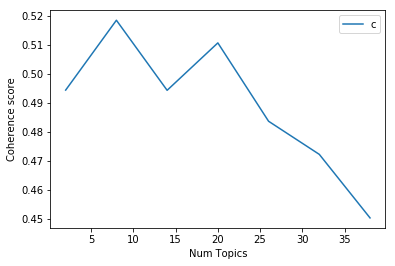

In [22]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4944
Num Topics = 8  has Coherence Value of 0.5185
Num Topics = 14  has Coherence Value of 0.4943
Num Topics = 20  has Coherence Value of 0.5107
Num Topics = 26  has Coherence Value of 0.4837
Num Topics = 32  has Coherence Value of 0.4722
Num Topics = 38  has Coherence Value of 0.4503


In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.126*"hand" + 0.120*"catch" + 0.052*"pull" + 0.051*"conveyor" + '
  '0.050*"finger" + 0.048*"leave" + 0.046*"belt" + 0.041*"chain" + '
  '0.031*"amputate" + 0.026*"remove"'),
 (1,
  '0.191*"machine" + 0.052*"time" + 0.050*"hand" + 0.045*"part" + '
  '0.038*"press" + 0.028*"incident" + 0.023*"attempt" + 0.023*"operating" + '
  '0.021*"guard" + 0.019*"operate"'),
 (2,
  '0.134*"truck" + 0.068*"back" + 0.063*"trailer" + 0.038*"load" + '
  '0.036*"vehicle" + 0.033*"employee" + 0.027*"side" + 0.022*"loading" + '
  '0.022*"strike" + 0.022*"dock"'),
 (3,
  '0.283*"employee" + 0.092*"work" + 0.082*"arm" + 0.043*"suffer" + '
  '0.036*"equipment" + 0.035*"perform" + 0.031*"maintenance" + 0.023*"remove" '
  '+ 0.020*"unit" + 0.019*"system"'),
 (4,
  '0.229*"employee" + 0.126*"require" + 0.088*"surgery" + '
  '0.083*"hospitalization" + 0.064*"door" + 0.043*"injure" + 0.027*"open" + '
  '0.026*"close" + 0.018*"panel" + 0.017*"suffer"'),
 (5,
  '0.165*"foot" + 0.121*"fall" + 0.100*"ladder" 

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.1134,"employee, move, leave, left, table, cart, push...",Three correctional facility guards were escort...
1,1,16.0,0.1083,"burn, line, face, water, receive, tank, hose, ...",Employee in the Machine Shop received second d...
2,2,5.0,0.1137,"foot, fall, ladder, ground, approximately, los...",A truck driver fell approximately 4 feet while...
3,3,10.0,0.0998,"forklift, pallet, leg, foot, strike, jack, emp...",An employees leg was pinned between a truck an...
4,4,1.0,0.1239,"machine, time, hand, part, press, incident, at...",An employee working on the Line 6 Auto-Beller ...
5,5,6.0,0.0690,"employee, lift, crane, wall, top, cable, place...",An employee was hospitalized after slipping an...
6,6,1.0,0.0738,"machine, time, hand, part, press, incident, at...",Employee working the flipping machine at the c...
7,7,16.0,0.1064,"burn, line, face, water, receive, tank, hose, ...",Employee sustained burns during line tie-in op...
8,8,9.0,0.0951,"employee, hospitalize, work, due, begin, overn...",One employee was hospitalized after being stru...
9,9,15.0,0.0789,"cut, thumb, employee, tip, blade, hand, leave,...",An associate was using a knife to open a bag o...


In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2761,"hand, catch, pull, conveyor, finger, leave, be...",Employees were trimming a tree. A branch got c...
1,1.0,0.3004,"machine, time, hand, part, press, incident, at...",An employee was clearing a jam and jogging the...
2,2.0,0.2638,"truck, back, trailer, load, vehicle, employee,...","An employee was driving a tri-axle dump truck,..."
3,3.0,0.2760,"employee, work, arm, suffer, equipment, perfor...",An electrical maintenance technician was troub...
4,4.0,0.1941,"employee, require, surgery, hospitalization, d...","On 09/01/2015, at approximately 08:55 a.m., an..."


In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,14.0,"employee, move, leave, left, table, cart, push...",954.0,0.0442
1,16.0,"burn, line, face, water, receive, tank, hose, ...",1356.0,0.0628
2,5.0,"foot, fall, ladder, ground, approximately, los...",1321.0,0.0612
3,10.0,"forklift, pallet, leg, foot, strike, jack, emp...",476.0,0.0221
4,1.0,"machine, time, hand, part, press, incident, at...",832.0,0.0386
5,6.0,"employee, lift, crane, wall, top, cable, place...",1819.0,0.0843
6,1.0,"machine, time, hand, part, press, incident, at...",782.0,0.0362
7,16.0,"burn, line, face, water, receive, tank, hose, ...",865.0,0.0401
8,9.0,"employee, hospitalize, work, due, begin, overn...",1417.0,0.0657
9,15.0,"cut, thumb, employee, tip, blade, hand, leave,...",1122.0,0.0520
